# Modelos cambiando la profundidad del árbol 

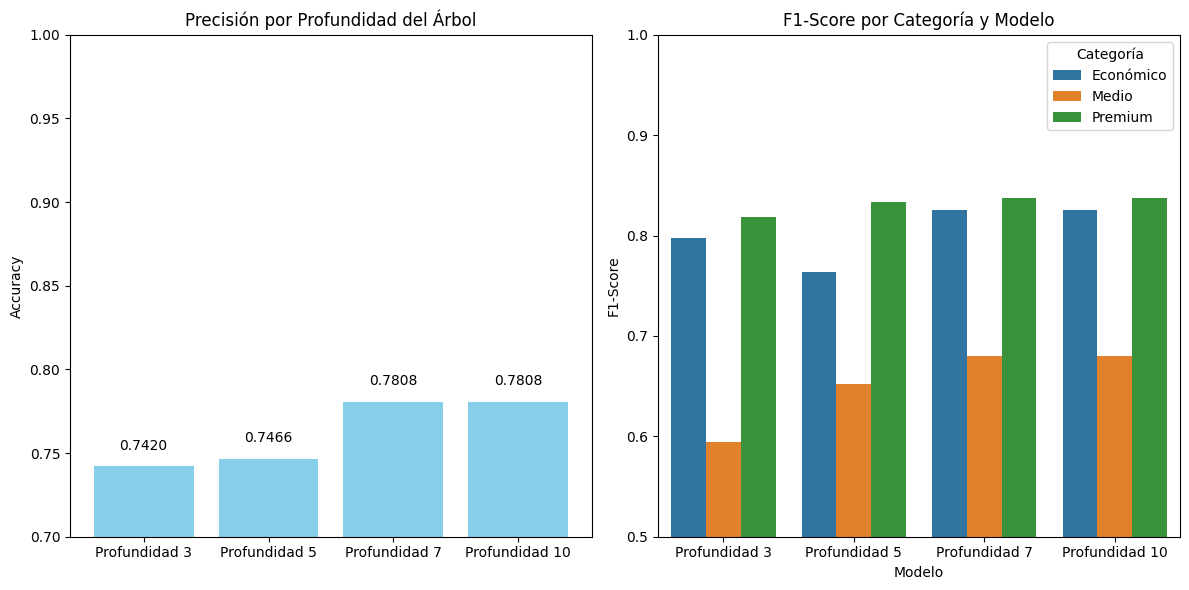


--- COMPARACIÓN DE MODELOS ---
   Profundidad  Accuracy  F1_Económico  F1_Medio  F1_Premium
0            3  0.742009      0.797508  0.594796    0.818182
1            5  0.746575      0.763636  0.651757    0.833333
2            7  0.780822      0.825939  0.680272    0.837370
3           10  0.780822      0.825939  0.680272    0.837370

El mejor modelo es el árbol con profundidad 7, con accuracy: 0.7808

--- ANÁLISIS DE LA PROFUNDIDAD ÓPTIMA ---
El modelo con profundidad 7 proporciona el mejor equilibrio entre complejidad y precisión.
Accuracy: 0.7808
F1-Score promedio: 0.7812


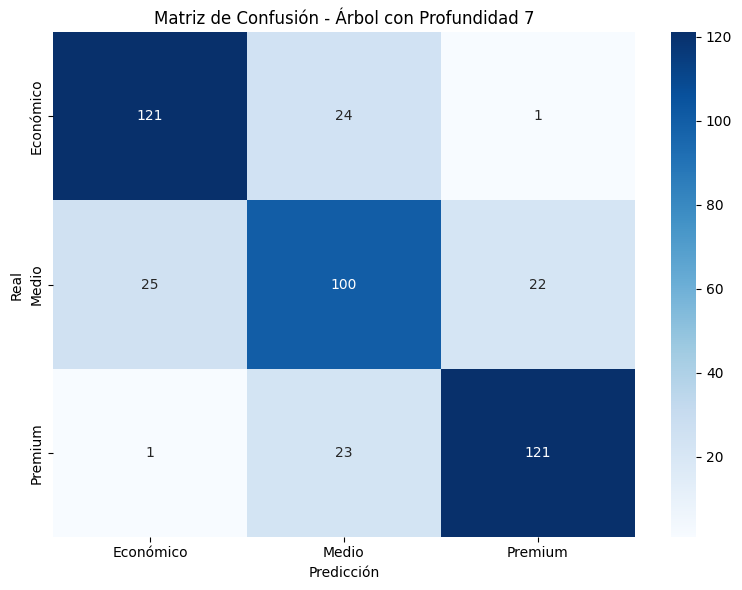

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# 1. Cargar los datos
df = pd.read_csv('../../train.csv')

# 2. Crear variable de respuesta categórica basada en terciles
tercil_1 = df['SalePrice'].quantile(1/3)
tercil_2 = df['SalePrice'].quantile(2/3)
df['PriceCategory'] = pd.cut(
    df['SalePrice'], 
    bins=[0, tercil_1, tercil_2, float('inf')], 
    labels=['Económico', 'Medio', 'Premium']
)

# 3. Seleccionar características importantes
selected_features = [
    'OverallQual',    # Calidad general
    'GrLivArea',      # Área habitable
    'GarageCars',     # Capacidad del garaje
    'YearBuilt',      # Año de construcción
    'TotalBsmtSF',    # Superficie total del sótano
    'FullBath',       # Baños completos
    'Neighborhood',   # Vecindario (categórica)
    'ExterQual',      # Calidad del exterior (categórica)
    'KitchenQual',    # Calidad de la cocina (categórica)
    'BsmtQual'        # Calidad del sótano (categórica)
]

# 4. Preparar los datos
X = df[selected_features].copy()
y = df['PriceCategory']

# Manejar valores faltantes en características numéricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
imputer = SimpleImputer(strategy='median')
X[numeric_features] = imputer.fit_transform(X[numeric_features])

# Manejar valores faltantes en características categóricas
categorical_features = X.select_dtypes(include=['object']).columns
X[categorical_features] = X[categorical_features].fillna('None')

# Codificar variables categóricas
for feature in categorical_features:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature])

# 5. Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 6. Crear modelos con diferentes profundidades
depths = [3, 5, 7, 10]
models = {}
results = {}

for depth in depths:
    # Crear y entrenar el modelo
    model_name = f"Tree_Depth_{depth}"
    models[model_name] = DecisionTreeClassifier(
        max_depth=depth,             
        min_samples_split=20,    
        min_samples_leaf=10,     
        random_state=42
    )
    
    models[model_name].fit(X_train, y_train)
    
    # Realizar predicciones
    y_pred = models[model_name].predict(X_test)
    
    # Guardar resultados
    results[model_name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'conf_matrix': confusion_matrix(y_test, y_pred),
        'report': classification_report(y_test, y_pred, output_dict=True),
        'feature_importance': models[model_name].feature_importances_
    }

# 7. Visualizar resultados
plt.figure(figsize=(12, 6))

# Gráfico de barras para accuracy
plt.subplot(1, 2, 1)
accuracies = [results[f"Tree_Depth_{depth}"]['accuracy'] for depth in depths]
plt.bar([f"Profundidad {depth}" for depth in depths], accuracies, color='skyblue')
plt.ylim(0.7, 1.0)  # Ajustar según los valores reales
plt.title('Precisión por Profundidad del Árbol')
plt.ylabel('Accuracy')
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')

# Gráfico con métricas por clase para cada modelo
plt.subplot(1, 2, 2)
metrics = []
for depth in depths:
    model_name = f"Tree_Depth_{depth}"
    report = results[model_name]['report']
    for category in ['Económico', 'Medio', 'Premium']:
        metrics.append({
            'Modelo': f"Profundidad {depth}",
            'Categoría': category,
            'F1-Score': report[category]['f1-score']
        })

metrics_df = pd.DataFrame(metrics)
sns.barplot(x='Modelo', y='F1-Score', hue='Categoría', data=metrics_df)
plt.title('F1-Score por Categoría y Modelo')
plt.ylim(0.5, 1.0)  # Ajustar según los valores reales

plt.tight_layout()
plt.show()

# 8. Tabla comparativa
comparison = pd.DataFrame({
    'Profundidad': depths,
    'Accuracy': [results[f"Tree_Depth_{depth}"]['accuracy'] for depth in depths],
    'F1_Económico': [results[f"Tree_Depth_{depth}"]['report']['Económico']['f1-score'] for depth in depths],
    'F1_Medio': [results[f"Tree_Depth_{depth}"]['report']['Medio']['f1-score'] for depth in depths],
    'F1_Premium': [results[f"Tree_Depth_{depth}"]['report']['Premium']['f1-score'] for depth in depths],
})

print("\n--- COMPARACIÓN DE MODELOS ---")
print(comparison)

# 9. Determinar el mejor modelo
best_depth = depths[np.argmax([results[f"Tree_Depth_{depth}"]['accuracy'] for depth in depths])]
print(f"\nEl mejor modelo es el árbol con profundidad {best_depth}, con accuracy: {results[f'Tree_Depth_{best_depth}']['accuracy']:.4f}")

# 10. Análisis de la profundidad óptima
print("\n--- ANÁLISIS DE LA PROFUNDIDAD ÓPTIMA ---")
print(f"El modelo con profundidad {best_depth} proporciona el mejor equilibrio entre complejidad y precisión.")
print(f"Accuracy: {results[f'Tree_Depth_{best_depth}']['accuracy']:.4f}")
print(f"F1-Score promedio: {(results[f'Tree_Depth_{best_depth}']['report']['Económico']['f1-score'] + results[f'Tree_Depth_{best_depth}']['report']['Medio']['f1-score'] + results[f'Tree_Depth_{best_depth}']['report']['Premium']['f1-score'])/3:.4f}")

# Mostrar la matriz de confusión del mejor modelo
plt.figure(figsize=(8, 6))
sns.heatmap(
    results[f'Tree_Depth_{best_depth}']['conf_matrix'], 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['Económico', 'Medio', 'Premium'],
    yticklabels=['Económico', 'Medio', 'Premium']
)
plt.title(f'Matriz de Confusión - Árbol con Profundidad {best_depth}')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.show()